# Basic example of CausalKit workflow

This notebook covers scenario:
| Is RCT        | Treatment | Outcome    | EDA | Estimands | Refutation |
|---------------|-----------|------------|-----|-----------|------------|
| Observational | Binary    | Continuous | Yes | ATE       | Yes        |

We will estimate Average Treatment Effect (ATE) of binary treatment on continuous outcome. It shows explonatary data analysis and refutation tests

## Generate data

Let's generate data of how feature (Treatment) impact on ARPU (Outcome) with linear effect (theta) = 1.8

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from causalkit.data import CausalDatasetGenerator, CausalData

# Reproducibility
np.random.seed(42)

confounder_specs = [
    {"name": "tenure_months", "dist": "normal", "mu": 24, "sd": 12},
    {"name": "avg_sessions_week", "dist": "normal", "mu": 5, "sd": 2},
    {"name": "spend_last_month", "dist": "uniform", "a": 0, "b": 200},
    {"name": "premium_user", "dist": "bernoulli", "p": 0.25},
    {"name": "urban_resident", "dist": "bernoulli", "p": 0.60},
]

# Causal effect and noise
theta = 1.8  # ATE: +1.8 ARPU units if new_feature = 1
sigma_y = 3.5  # ARPU noise std
target_t_rate = 0.35  # ~35% treated

# Effects of confounders on ARPU (baseline, additive)
# Order: tenure_months, avg_sessions_week, spend_last_month, premium_user, urban_resident
beta_y = np.array([
    0.05,  # tenure_months: small positive effect
    0.40,  # avg_sessions_week: strong positive effect
    0.02,  # spend_last_month: recent spend correlates with ARPU
    2.00,  # premium_user: premium users have higher ARPU
    1.00,  # urban_resident: urban users slightly higher ARPU
], dtype=float)

# Effects of confounders on treatment assignment (log-odds scale)
beta_t = np.array([
    0.015,  # tenure_months
    0.10,  # avg_sessions_week
    0.002,  # spend_last_month
    0.75,  # premium_user
    0.30,  # urban_resident: more likely to get the feature
], dtype=float)

gen = CausalDatasetGenerator(
    theta=theta,
    outcome_type="continuous",
    sigma_y=sigma_y,
    target_t_rate=target_t_rate,
    seed=42,
    confounder_specs=confounder_specs,
    beta_y=beta_y,
    beta_t=beta_t,
)


# Create dataset
causal_data = gen.to_causal_data(
    n=10000,
    confounders = [
    "tenure_months",
    "avg_sessions_week",
    "spend_last_month",
    "premium_user",
    "urban_resident",
]
)

# Show first few rows
causal_data.df.head()


,y,t,tenure_months,avg_sessions_week,spend_last_month,premium_user,urban_resident
0,5.927714,1.0,27.656605,5.352554,72.552568,1.0,0.0
1,11.122008,1.0,11.520191,6.798247,188.481287,1.0,0.0
2,10.580393,1.0,33.005414,2.055459,51.040440,0.0,1.0
3,6.982844,1.0,35.286777,4.429404,166.992239,0.0,1.0
4,10.899381,0.0,0.587578,6.658307,179.371126,0.0,0.0


## EDA


In [2]:
from causalkit.eda import CausalEDA
eda = CausalEDA(causal_data)

### General dataset information

Let's see how outcome differ between clients who recieved the feature and didn't

In [3]:
# shape of data
eda.data_shape()

{'n_rows': 10000, 'n_columns': 7}

In [4]:
# 1) Outcome statistics by treatment
eda.outcome_stats()

,count,mean,std,min,p10,p25,median,p75,p90,max
treatment,,,,,,,,,,
0.0,6519,6.011340,3.925893,-9.866447,1.012888,3.426894,6.030504,8.676781,10.952265,20.770359
1.0,3481,8.553615,3.934260,-5.507710,3.525225,5.909860,8.566860,11.216054,13.602967,21.377687


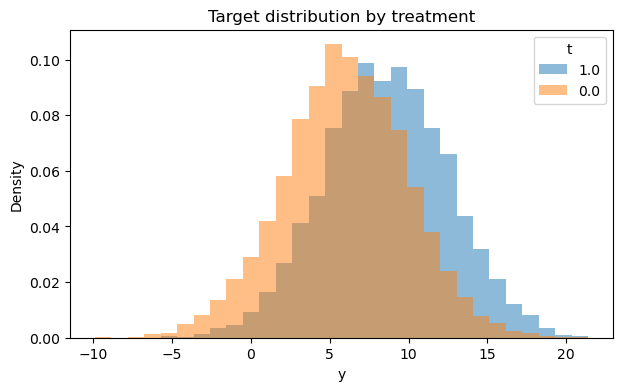

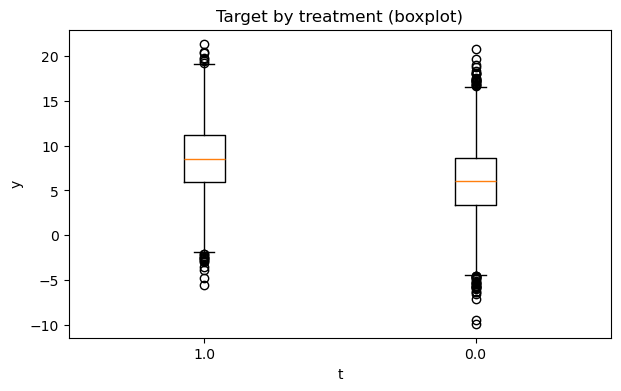

In [5]:
# 2) Outcome distribution by treatment (hist + boxplot)
fig1, fig2 = eda.outcome_plots()
plt.show()

### Propensity

Now let's examine how propensity score differ treatments

In [6]:
# Shows means of confounders for control/treated groups, absolute differences, and SMD values
confounders_balance_df = eda.confounders_means()
display(confounders_balance_df)

,mean_t_0,mean_t_1,abs_diff,smd
confounders,,,,
premium_user,0.198343,0.347889,0.149545,0.340423
avg_sessions_week,4.905841,5.293265,0.387423,0.193959
tenure_months,23.170108,25.200827,2.030718,0.168676
urban_resident,0.578003,0.643781,0.065778,0.135209
spend_last_month,97.801230,105.271930,7.470700,0.129267


In [7]:
# Propensity model fit
ps_model = eda.fit_propensity()

# ROC AUC - shows how predictable treatment is from confounders
roc_auc_score = ps_model.roc_auc
print("ROC AUC from PropensityModel:", round(roc_auc_score, 4))

ROC AUC from PropensityModel: 0.6053


In [8]:
# Positivity check - assess overlap between treatment groups
positivity_result = ps_model.positivity_check()
print("Positivity check from PropensityModel:", positivity_result)

Positivity check from PropensityModel: {'bounds': (0.05, 0.95), 'share_below': 0.0008, 'share_above': 0.0, 'flag': False}


In [9]:
# SHAP values - feature importance for treatment assignment from confounders
shap_values_df = ps_model.shap
display(shap_values_df)

,feature,shap_mean
0,spend_last_month,-0.000322
1,tenure_months,0.000140
2,avg_sessions_week,0.000122
3,premium_user,0.000052
4,urban_resident,0.000008


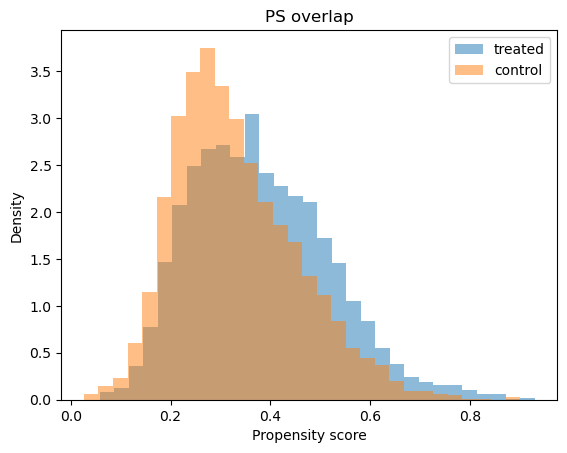

In [10]:
# Propensity score overlap graph
ps_model.ps_graph()
plt.show()

### Outcome regression

Let's analyze how confounders predict outcome

In [11]:
# Outcome model fit
outcome_model = eda.outcome_fit()

# RMSE and MAE of regression model
print(outcome_model.scores)

{'rmse': 3.6896558290948964, 'mae': 2.94099663606919}


In [12]:
# 2) SHAP values - feature importance for outcome prediction from confounders
shap_outcome_df = outcome_model.shap
display(shap_outcome_df)

,feature,shap_mean
0,spend_last_month,0.002252
1,tenure_months,-0.001747
2,avg_sessions_week,-0.000951
3,premium_user,0.000729
4,urban_resident,-0.000282


## Inference

Now time to estimate ATE with Double Machine Learning

In [13]:
from causalkit.inference.ate import dml_ate_source

# Estimate Average Treatment Effect (ATE)
ate_result = dml_ate_source(causal_data, n_folds=3, confidence_level=0.95)

In [14]:
ate_result

{'coefficient': 1.7547754158492368,
 'std_error': 0.08120639822820347,
 'p_value': 1.4835396169728733e-103,
 'confidence_interval': (1.5956138000077407, 1.913937031690733),
 'model': <doubleml.irm.irm.DoubleMLIRM at 0x15fd10830>}

True theta in our data generating proccess was 1.8

## Refutation

### Placebo

In [15]:
# Import refutation utilities
from causalkit.refutation import (
    refute_placebo_outcome,
    refute_placebo_treatment,
    refute_subset,
    refute_irm_orthogonality,
    sensitivity_analysis,
    sensitivity_analysis_set
)

Replacing outcome with dummy random variable must broke our model and effect will be near zero

In [16]:
# Replacing outcome with placebo
ate_placebo_outcome = refute_placebo_outcome(
    dml_ate_source,
    causal_data,
    random_state=42
)

print(ate_placebo_outcome)

{'theta': 0.0010896926888271316, 'p_value': 0.863664499475262}


Replacing treatment with dummy random variable must broke our model and effect will be near zero

In [17]:
# Replacing treatment with placebo
ate_placebo_treatment = refute_placebo_treatment(
    dml_ate_source,
    causal_data,
    random_state=42
)

print(ate_placebo_treatment)

{'theta': 0.05021278313460212, 'p_value': 0.5290821466624945}


Let's chanllege our dataset and romove random parts. Theta shoul be near estimated

In [18]:
# Inference on subsets
subset_fractions = [0.3, 0.5]

ate_subset_results = []
for fraction in subset_fractions:
    subset_result = refute_subset(
        dml_ate_source,
        causal_data,
        fraction=fraction,
        random_state=42
    )
    ate_subset_results.append(subset_result)

    print(f" With {fraction*100:.0f}% subset: theta = {subset_result['theta']:.4f}, p_value = {subset_result['p_value']:.4f}")

 With 30% subset: theta = 1.5725, p_value = 0.0000


 With 50% subset: theta = 1.8468, p_value = 0.0000


### Orthogonality

Orthogonality tests show us "Does we correct specify the model"

In [19]:
ate_ortho_check = refute_irm_orthogonality(dml_ate_source, causal_data)

In [20]:
# 1. Out-of-sample moment check
print("\n--- 1. Out-of-Sample Moment Check ---")
oos_test = ate_ortho_check['oos_moment_test']
print(f"T-statistic: {oos_test['tstat']:.4f}")
print(f"P-value: {oos_test['pvalue']:.4f}")
print(f"Interpretation: {oos_test['interpretation']}")
print("\nFold-wise results:")
display(oos_test['fold_results'])



--- 1. Out-of-Sample Moment Check ---
T-statistic: 0.3617
P-value: 0.7176
Interpretation: Should be ≈ 0 if moment condition holds

Fold-wise results:


,fold,n,psi_mean,psi_var
0,0,2000,0.142070,64.367381
1,1,2000,0.114837,71.748247
2,2,2000,0.106751,65.548761
3,3,2000,0.091285,62.569903
4,4,2000,-0.307471,68.208318


psi_mean is near zero on every fold, so the test is successful

In [21]:
# 2. Orthogonality derivatives
print("\n--- 2. Orthogonality (Gateaux Derivative) Tests ---")
ortho_derivs = ate_ortho_check['orthogonality_derivatives']
print(f"Interpretation: {ortho_derivs['interpretation']}")

print("\nFull sample derivatives:")
display(ortho_derivs['full_sample'])

print("\nTrimmed sample derivatives:")
display(ortho_derivs['trimmed_sample'])

if len(ortho_derivs['problematic_full']) > 0:
    print("\n⚠ PROBLEMATIC derivatives (full sample):")
    display(ortho_derivs['problematic_full'])
else:
    print("\n✓ No problematic derivatives in full sample")

if len(ortho_derivs['problematic_trimmed']) > 0:
    print("\n⚠ PROBLEMATIC derivatives (trimmed sample):")
    display(ortho_derivs['problematic_trimmed'])
else:
    print("\n✓ No problematic derivatives in trimmed sample")



--- 2. Orthogonality (Gateaux Derivative) Tests ---
Interpretation: Large |t-stats| (>2) indicate calibration issues

Full sample derivatives:


,basis,d_m1,se_m1,t_m1,d_m0,se_m0,t_m0,d_g,se_g,t_g
0,0,-0.027778,0.015464,-1.796300,0.009315,0.007849,1.186833,-0.103516,0.296654,-0.348945
1,1,0.005088,0.016336,0.311467,0.003259,0.008088,0.402935,0.137892,0.322104,0.428097
2,2,0.003129,0.016049,0.194959,0.000922,0.008162,0.112934,0.028325,0.385094,0.073553
3,3,-0.001588,0.014938,-0.106328,-0.000145,0.008205,-0.017732,0.021827,0.282692,0.077210
4,4,-0.000312,0.012767,-0.024401,0.002863,0.009497,0.301462,-0.019862,0.231095,-0.085947
5,5,0.000451,0.015937,0.028314,-0.001855,0.007660,-0.242168,0.138553,0.316203,0.438177



Trimmed sample derivatives:


,basis,d_m1,se_m1,t_m1,d_m0,se_m0,t_m0,d_g,se_g,t_g
0,0,-0.027778,0.015464,-1.796300,0.009315,0.007849,1.186833,-0.103516,0.296654,-0.348945
1,1,0.005088,0.016336,0.311467,0.003259,0.008088,0.402935,0.137892,0.322104,0.428097
2,2,0.003129,0.016049,0.194959,0.000922,0.008162,0.112934,0.028325,0.385094,0.073553
3,3,-0.001588,0.014938,-0.106328,-0.000145,0.008205,-0.017732,0.021827,0.282692,0.077210
4,4,-0.000312,0.012767,-0.024401,0.002863,0.009497,0.301462,-0.019862,0.231095,-0.085947
5,5,0.000451,0.015937,0.028314,-0.001855,0.007660,-0.242168,0.138553,0.316203,0.438177



✓ No problematic derivatives in full sample

✓ No problematic derivatives in trimmed sample


t_m1, t_m0, t_g should be above 2.
Even after trimming our data t_m1, t_m0, t_g above 2 across all confounders

In [22]:
# 3. Influence diagnostics
print("\n--- 3. Influence Diagnostics ---")
influence = ate_ortho_check['influence_diagnostics']
print(f"Interpretation: {influence['interpretation']}")

print("\nFull sample influence metrics:")
print(f"  Plugin SE: {influence['full_sample']['se_plugin']:.4f}")
print(f"  Kurtosis: {influence['full_sample']['kurtosis']:.2f}")
print(f"  P99/Median ratio: {influence['full_sample']['p99_over_med']:.2f}")

print("\nTrimmed sample influence metrics:")
print(f"  Plugin SE: {influence['trimmed_sample']['se_plugin']:.4f}")
print(f"  Kurtosis: {influence['trimmed_sample']['kurtosis']:.2f}")
print(f"  P99/Median ratio: {influence['trimmed_sample']['p99_over_med']:.2f}")

print("\nTop influential observations (full sample):")
display(influence['full_sample']['top_influential'])



--- 3. Influence Diagnostics ---
Interpretation: Heavy tails or extreme kurtosis suggest instability

Full sample influence metrics:
  Plugin SE: 0.0815
  Kurtosis: 7.64
  P99/Median ratio: 6.59

Trimmed sample influence metrics:
  Plugin SE: 0.0815
  Kurtosis: 7.64
  P99/Median ratio: 6.59

Top influential observations (full sample):


,i,psi,g,res_t,res_c
0,7299,-78.668133,0.100071,-7.970469,-0.000000
1,874,63.471801,0.116169,8.132480,0.000000
2,9405,49.195863,0.169723,8.457407,0.000000
3,9116,-46.282651,0.164969,-7.989467,-0.000000
4,294,-44.627395,0.213603,-9.570962,-0.000000
5,7634,44.388611,0.742768,-0.000000,-12.113462
6,8409,44.028348,0.284715,12.696785,0.000000
7,5821,-43.885460,0.153316,-6.377281,-0.000000
8,8085,-43.798883,0.247829,-11.536566,-0.000000
9,731,43.545110,0.165439,6.820135,0.000000


In [23]:
# Trimming information
print("\n--- Propensity Score Trimming ---")
trim_info = ate_ortho_check['trimming_info']
print(f"Trimming bounds: {trim_info['bounds']}")
print(f"Observations trimmed: {trim_info['n_trimmed']} ({trim_info['pct_trimmed']:.1f}%)")



--- Propensity Score Trimming ---
Trimming bounds: (0.02, 0.98)
Observations trimmed: 0 (0.0%)


In this test we analyze distribution of theta before trimming and after. There is no big difference. So test passed

In [24]:
# Diagnostic conditions breakdown
print("\n--- Diagnostic Conditions Assessment ---")
conditions = ate_ortho_check['diagnostic_conditions']

print("Individual condition checks:")
for condition, passed in conditions.items():
    status = "✓ PASS" if passed else "✗ FAIL"
    print(f"  {condition}: {status}")

print(f"\nOverall: {ate_ortho_check['overall_assessment']}")



--- Diagnostic Conditions Assessment ---
Individual condition checks:
  oos_moment_ok: ✓ PASS
  derivs_full_ok: ✓ PASS
  derivs_trim_ok: ✓ PASS
  se_reasonable: ✓ PASS
  no_extreme_influence: ✓ PASS
  trimming_reasonable: ✓ PASS

Overall: PASS: Strong evidence for orthogonality


### Sensitivity analysis

Let's analyze how unobserved confounder could look

In [25]:
bench_sets = causal_data.confounders
res = sensitivity_analysis_set(
    ate_result,
    benchmarking_set=bench_sets,
    level=0.95,
    null_hypothesis=0.0,
)

In [26]:
# Build a DataFrame with confounders as rows and the metrics as columns
summary_df = pd.DataFrame({
    name: (df.loc['t'] if 't' in df.index else df.iloc[0])
    for name, df in res.items()
}).T


In [27]:
summary_df

,cf_y,cf_d,rho,delta_theta
tenure_months,0.019343,0.004555,1.000000,0.125310
avg_sessions_week,0.031075,0.010474,1.000000,0.172854
spend_last_month,0.080634,0.006735,0.982448,0.177995
premium_user,0.062270,0.031318,1.000000,0.360557
urban_resident,0.018716,0.000000,1.000000,0.093394


It is business domain and data knowledge relative question. In this situation we will stop on the most influential confounder 'premium_user' and test theta when we do not observe anothere confounder with strength of 'premium_user'

In [28]:
# Run sensitivity analysis on our ATE result
sensitivity_report_1 = sensitivity_analysis(
    ate_result,
    cf_y=0.06,  # Confounding strength affecting outcome
    cf_d=0.03,  # Confounding strength affecting treatment
    rho=1.0     # Perfect correlation between unobserved confounders
)

print(sensitivity_report_1)

================== Sensitivity Analysis ==================

------------------ Scenario          ------------------
Significance Level: level=0.95
Sensitivity parameters: cf_y=0.06; cf_d=0.03, rho=1.0

------------------ Bounds with CI    ------------------
   CI lower  theta lower     theta  theta upper  CI upper
t  1.284916     1.418741  1.754775      2.09081  2.224353

------------------ Robustness Values ------------------
   H_0     RV (%)    RVa (%)
t  0.0  20.106836  18.701604


CI lower >> 0. It means test is passed